In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import argparse
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
def load_pep_and_codify(file, max_len):
    aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,'L':11,'K':12,'M':13,'F':14,
        'P':15,'O':16,'S':17,'U':18,'T':19,'W':20,'Y':21,'V':22}
    with open(file, 'r') as inf:
        lines = inf.read().splitlines()
    pep_codes=[]
    long_pep_counter = 0
    newLines = []
    for pep in lines:
        if not len(pep) > max_len:
            current_pep=[]
            for aa in pep:
                current_pep.append(aa_dict[aa])
            pep_codes.append(current_pep)
            newLines.extend([pep])
        else:
            long_pep_counter += 1
    predict_data = keras.preprocessing.sequence.pad_sequences(pep_codes, value=0, padding='post', maxlen=max_len)
    return predict_data, long_pep_counter, newLines

# New Train

In [3]:
model = tf.keras.Sequential([
    # vacabulary size 23 (22 AminoAcid + zero padding)
    # embedding vector size 50
    # input length (including padding) 30 ( 81 to 30)
    tf.keras.layers.Embedding(23, 50, input_length=30),
    tf.keras.layers.Dropout(np.random.uniform(0, 0.2)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.Conv1D(filters=64, kernel_size=2, strides=1),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(np.random.uniform(0, 0.2)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 50)            1150      
_________________________________________________________________
dropout (Dropout)            (None, 30, 50)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 30, 128)           19328     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 29, 64)            16448     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
__________________

# 1. Make Data X_train, y_train, X_test, y_test

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

file_path = '../compareModel/2019Bioinformatics_DeepMSPeptide/DeepMSPeptide/'

In [19]:
# make DeepMSpeptide format
df_peptide_train = pd.read_csv('../data/df_detect_peptide_train_noptm_210930_includeDigest.csv')
df_peptide_test = pd.read_csv('../data/df_detect_peptide_test_noptm_210930_includeDigest.csv')

inp = open(file_path+'detect_peptide_train_noptm.txt', 'w')
inp_y = open(file_path+'detect_peptide_train_y_noptm.txt', 'w')
for x, y in df_peptide_train[['PEP', 'ID']].values:
    inp.write(x+'\n')
    inp_y.write(str(y)+'\n')
inp.close()
inp_y.close()

inp = open(file_path+'detect_peptide_test_noptm.txt', 'w')
inp_y = open(file_path+'detect_peptide_test_y_noptm.txt', 'w')
for x, y in df_peptide_test[['PEP', 'ID']].values:
    inp.write(x+'\n')
    inp_y.write(str(y)+'\n')
inp.close()
inp_y.close()

args = file_path + 'detect_peptide_train_noptm.txt'
print('Loading input peptides')
X_train, skipped, lines = load_pep_and_codify(args, 30)
tmp = open(file_path+'detect_peptide_train_y_noptm.txt')
y_train = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

args = file_path + 'detect_peptide_test_noptm.txt'
print('Loading input peptides')
X_test, skipped, lines = load_pep_and_codify(args, 30)
tmp = open(file_path+'detect_peptide_test_y_noptm.txt')
y_test = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

Loading input peptides
Succesfully loaded 421474 peptides and skipped 0
Loading input peptides
Succesfully loaded 88998 peptides and skipped 0
(337179, 30) (84295, 30) (88998, 30) (337179,) (84295,) (88998,)


# 2. train

In [20]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [21]:
history = model.fit(X_train, y_train, epochs=200, 
                    batch_size=100,
                    validation_data=(X_val, y_val))

Train on 337179 samples, validate on 84295 samples
Epoch 1/200
337179/337179 [==============================] - 58s 171us/sample - loss: 0.6064 - acc: 0.7660 - val_loss: 0.5977 - val_acc: 0.7916
Epoch 2/200
337179/337179 [==============================] - 57s 170us/sample - loss: 0.5960 - acc: 0.7957 - val_loss: 0.5935 - val_acc: 0.8062
Epoch 3/200
337179/337179 [==============================] - 56s 166us/sample - loss: 0.5939 - acc: 0.8016 - val_loss: 0.5931 - val_acc: 0.8020
Epoch 4/200
337179/337179 [==============================] - 58s 173us/sample - loss: 0.5930 - acc: 0.8039 - val_loss: 0.5925 - val_acc: 0.8031
Epoch 5/200
337179/337179 [==============================] - 57s 170us/sample - loss: 0.5925 - acc: 0.8046 - val_loss: 0.5914 - val_acc: 0.8087
Epoch 6/200
337179/337179 [==============================] - 58s 171us/sample - loss: 0.5919 - acc: 0.8062 - val_loss: 0.5909 - val_acc: 0.8126
Epoch 7/200
337179/337179 [==============================] - 58s 173us/sample - loss:

337179/337179 [==============================] - 47s 139us/sample - loss: 0.5728 - acc: 0.8472 - val_loss: 0.5762 - val_acc: 0.8446
Epoch 114/200
337179/337179 [==============================] - 44s 131us/sample - loss: 0.5732 - acc: 0.8466 - val_loss: 0.5769 - val_acc: 0.8402
Epoch 115/200
337179/337179 [==============================] - 47s 139us/sample - loss: 0.5729 - acc: 0.8473 - val_loss: 0.5755 - val_acc: 0.8444
Epoch 116/200
337179/337179 [==============================] - 46s 136us/sample - loss: 0.5728 - acc: 0.8468 - val_loss: 0.5760 - val_acc: 0.8358
Epoch 117/200
337179/337179 [==============================] - 47s 140us/sample - loss: 0.5728 - acc: 0.8469 - val_loss: 0.5760 - val_acc: 0.8351
Epoch 118/200
337179/337179 [==============================] - 45s 132us/sample - loss: 0.5727 - acc: 0.8473 - val_loss: 0.5758 - val_acc: 0.8440
Epoch 119/200
337179/337179 [==============================] - 46s 137us/sample - loss: 0.5729 - acc: 0.8466 - val_loss: 0.5760 - val_acc:

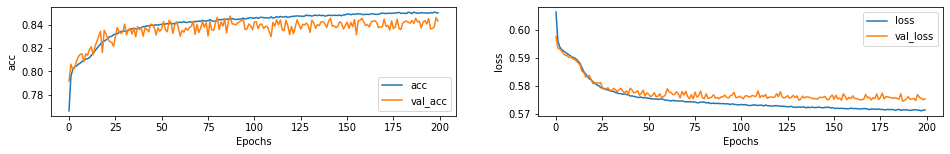

In [22]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'acc')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# 2-2. Github code

Loading input peptides
Succesfully loaded 421474 peptides and skipped 0
Loading input peptides
Succesfully loaded 88998 peptides and skipped 0
(337179, 81) (84295, 81) (88998, 81) (337179,) (84295,) (88998,)
Loading model...
Train on 337179 samples, validate on 84295 samples
Epoch 1/200
337179/337179 [==============================] - 42s 125us/sample - loss: 0.4377 - acc: 0.7897 - binary_crossentropy: 0.4377 - val_loss: 0.3726 - val_acc: 0.8292 - val_binary_crossentropy: 0.3726
Epoch 2/200
337179/337179 [==============================] - 41s 121us/sample - loss: 0.3780 - acc: 0.8287 - binary_crossentropy: 0.3780 - val_loss: 0.3588 - val_acc: 0.8363 - val_binary_crossentropy: 0.3588
Epoch 3/200
337179/337179 [==============================] - 41s 122us/sample - loss: 0.3658 - acc: 0.8357 - binary_crossentropy: 0.3658 - val_loss: 0.3505 - val_acc: 0.8418 - val_binary_crossentropy: 0.3505
Epoch 4/200
337179/337179 [==============================] - 41s 121us/sample - loss: 0.3601 - acc: 

337179/337179 [==============================] - 40s 120us/sample - loss: 0.3166 - acc: 0.8605 - binary_crossentropy: 0.3166 - val_loss: 0.3398 - val_acc: 0.8503 - val_binary_crossentropy: 0.3398
Epoch 78/200
337179/337179 [==============================] - 41s 121us/sample - loss: 0.3169 - acc: 0.8609 - binary_crossentropy: 0.3169 - val_loss: 0.3363 - val_acc: 0.8505 - val_binary_crossentropy: 0.3363
Epoch 79/200
337179/337179 [==============================] - 41s 120us/sample - loss: 0.3160 - acc: 0.8613 - binary_crossentropy: 0.3160 - val_loss: 0.3499 - val_acc: 0.8491 - val_binary_crossentropy: 0.3499
Epoch 80/200
337179/337179 [==============================] - 40s 119us/sample - loss: 0.3164 - acc: 0.8608 - binary_crossentropy: 0.3164 - val_loss: 0.3382 - val_acc: 0.8490 - val_binary_crossentropy: 0.3382
Epoch 81/200
337179/337179 [==============================] - 40s 120us/sample - loss: 0.3165 - acc: 0.8606 - binary_crossentropy: 0.3165 - val_loss: 0.3392 - val_acc: 0.8507 - 

337179/337179 [==============================] - 61s 180us/sample - loss: 0.3089 - acc: 0.8647 - binary_crossentropy: 0.3089 - val_loss: 0.3414 - val_acc: 0.8481 - val_binary_crossentropy: 0.3414
Epoch 156/200
337179/337179 [==============================] - 60s 177us/sample - loss: 0.3096 - acc: 0.8644 - binary_crossentropy: 0.3096 - val_loss: 0.3374 - val_acc: 0.8484 - val_binary_crossentropy: 0.3374
Epoch 157/200
337179/337179 [==============================] - 61s 180us/sample - loss: 0.3091 - acc: 0.8641 - binary_crossentropy: 0.3091 - val_loss: 0.3434 - val_acc: 0.8495 - val_binary_crossentropy: 0.3434
Epoch 158/200
337179/337179 [==============================] - 60s 177us/sample - loss: 0.3094 - acc: 0.8639 - binary_crossentropy: 0.3094 - val_loss: 0.3370 - val_acc: 0.8518 - val_binary_crossentropy: 0.3370
Epoch 159/200
337179/337179 [==============================] - 59s 176us/sample - loss: 0.3093 - acc: 0.8642 - binary_crossentropy: 0.3093 - val_loss: 0.3446 - val_acc: 0.850

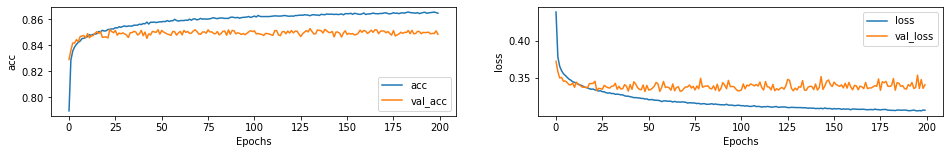

In [18]:
args = file_path + 'detect_peptide_train_noptm.txt'
print('Loading input peptides')
X_train81, skipped, lines = load_pep_and_codify(args, 81)
tmp = open(file_path+'detect_peptide_train_y_noptm.txt')
y_train81 = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

args = file_path + 'detect_peptide_test_noptm.txt'
print('Loading input peptides')
X_test81, skipped, lines = load_pep_and_codify(args, 81)
tmp = open(file_path+'detect_peptide_test_y_noptm.txt')
y_test81 = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

X_train81, X_val81, y_train81, y_val81 = train_test_split(X_train81, y_train81, test_size=0.2)
print(X_train81.shape, X_val81.shape, X_test81.shape, y_train81.shape, y_val81.shape, y_test81.shape)


print('Loading model...')
model_2_1D = keras.models.load_model(file_path + 'model_2_1D.h5')

history_github = model_2_1D.fit(X_train81, y_train81, epochs=200, 
                    batch_size=100,
                    validation_data=(X_val81, y_val81))

plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history_github, 'acc')
plt.subplot(1,2,2)
plot_graphs(history_github, 'loss')

# 3. test

In [23]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns

In [24]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

88998/88998 [==============================] - 7s 80us/sample - loss: 0.5710 - acc: 0.8630
Test Loss: 0.5710091826947834
Test Accuracy: 0.8630081415176392


              precision    recall  f1-score   support

           0       0.86      0.86      0.86     44509
           1       0.86      0.86      0.86     44489

    accuracy                           0.86     88998
   macro avg       0.86      0.86      0.86     88998
weighted avg       0.86      0.86      0.86     88998

rf auc : 0.9230507935375096


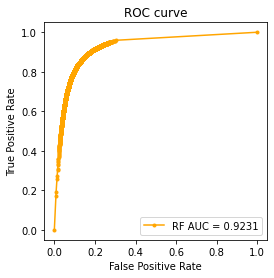

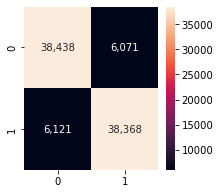

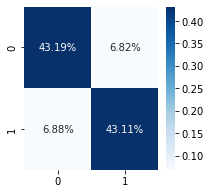

In [25]:
# prediction
y_pred = [1 if i>=0.5 else 0 for i in model.predict(X_test)]
print(classification_report(y_test, y_pred))
# AUC
probs = model.predict(X_test)
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

88998/88998 [==============================] - 9s 102us/sample - loss: 0.3434 - acc: 0.8515 - binary_crossentropy: 0.3434
Test Loss: 0.5710091826947834
Test Accuracy: [0.34338107316605804, 0.851536, 0.34338102]
              precision    recall  f1-score   support

           0       0.92      0.77      0.84     44509
           1       0.80      0.93      0.86     44489

    accuracy                           0.85     88998
   macro avg       0.86      0.85      0.85     88998
weighted avg       0.86      0.85      0.85     88998

rf auc : 0.9329487780851804


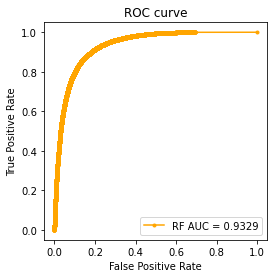

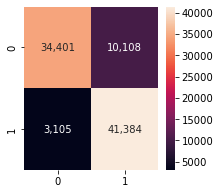

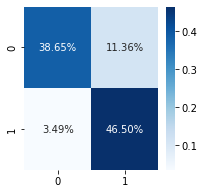

In [29]:
test_acc = model_2_1D.evaluate(X_test81, y_test81)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_2_1D.predict(X_test81)]
print(classification_report(y_test81, y_pred))
# AUC
probs = model_2_1D.predict(X_test81)
rf_auc = roc_auc_score(y_test81, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test81, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test81, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

In [30]:
import pickle

with open('pep_zeroMSGF_noptm.pickle', 'rb') as f:
    pep_zeroMSGF_noptm = pickle.load(f)

In [34]:
max_len=81

aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,'L':11,'K':12,'M':13,'F':14,
    'P':15,'O':16,'S':17,'U':18,'T':19,'W':20,'Y':21,'V':22}
pep_codes=[]
newLines = []
for pep in pep_zeroMSGF_noptm:
    if not len(pep) > max_len:
        current_pep=[]
        for aa in pep:
            current_pep.append(aa_dict[aa])
        pep_codes.append(current_pep)
        newLines.extend([pep])
predict_data = keras.preprocessing.sequence.pad_sequences(pep_codes, value=0, padding='post', maxlen=max_len)

In [35]:
predict_label = np.array([0]*len(predict_data))

In [36]:
test_acc = model_2_1D.evaluate(predict_data, predict_label)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_2_1D.predict(predict_data)]
print(classification_report(predict_label, y_pred))

93542/93542 [==============================] - 7s 74us/sample - loss: 1.0921 - acc: 0.5968 - binary_crossentropy: 1.0921
Test Loss: 0.5710091826947834
Test Accuracy: [1.0920911951762005, 0.5968442, 1.0920904]
              precision    recall  f1-score   support

           0       1.00      0.60      0.75     93542
           1       0.00      0.00      0.00         0

    accuracy                           0.60     93542
   macro avg       0.50      0.30      0.37     93542
weighted avg       1.00      0.60      0.75     93542



/home/bis/miniconda3/envs/TF1.14/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bis/miniconda3/envs/TF1.14/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bis/miniconda3/envs/TF1.14/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
y_prob = model_2_1D.predict(predict_data)

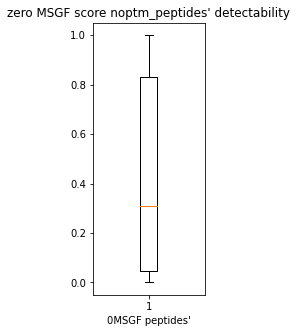

In [47]:
plt.figure(figsize=(2,5))
plt.boxplot(y_prob.reshape(-1))
plt.title('zero MSGF score noptm_peptides\' detectability')
plt.xlabel('0MSGF peptides\'')
plt.show()